In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import torch
from transformers import BertModel, BertTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

/Users/jonathanwang/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jonathanwang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jonathanwang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonathanwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Read the JSON file with line-separated JSON objects
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [3]:
# Drop link and date which would not be used as a feature
df = df.drop(columns=["link", "date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   headline           209527 non-null  object
 1   category           209527 non-null  object
 2   short_description  209527 non-null  object
 3   authors            209527 non-null  object
dtypes: object(4)
memory usage: 6.4+ MB


In [4]:
# EDA: Check for missing values
missing_values = df.isnull().sum()

# Display missing values count per column
print("Number of missing values:", missing_values, sep="\n")

Number of missing values:
headline             0
category             0
short_description    0
authors              0
dtype: int64


In [5]:
# EDA: Check for duplicates
duplicate_rows = df.duplicated()

# Count how many duplicates there are
num_duplicates = duplicate_rows.sum()

print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 447


In [8]:
# EDA: Remove duplicates
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209080 entries, 0 to 209526
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   headline           209080 non-null  object
 1   category           209080 non-null  object
 2   short_description  209080 non-null  object
 3   authors            209080 non-null  object
dtypes: object(4)
memory usage: 8.0+ MB


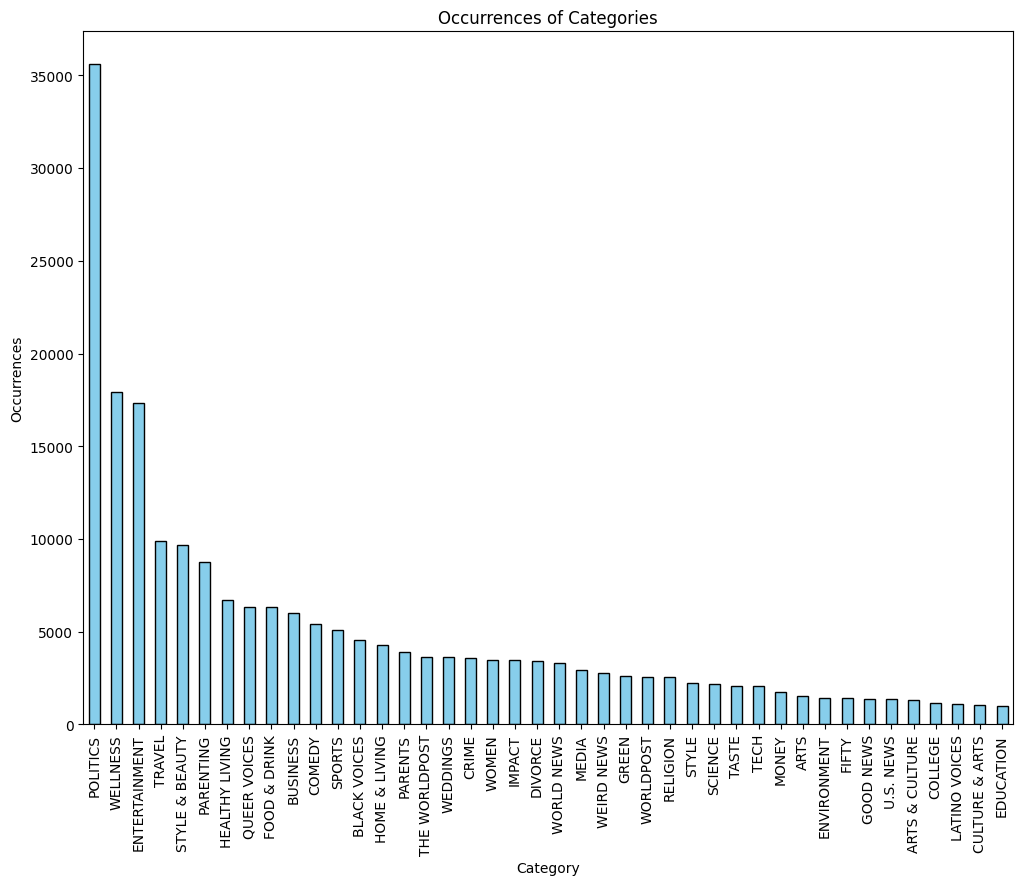

In [28]:
# EDA: Distribution of categories

# Count occurrences of each category
category_counts = df['category'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(12, 9))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Category')
plt.ylabel('Occurrences')
plt.title('Occurrences of Categories')

# Display the plot
plt.show()

In [9]:
# Tokenization, stop word removal, and lemmatization

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to process text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words and non-alphabetic tokens, and lemmatize the remaining words
    cleaned_tokens = [
        lemmatizer.lemmatize(word.lower())  # Convert to lowercase then lemmatize
        for word in tokens if word.isalpha() and word.lower() not in stop_words
    ]
    
    return " ".join(cleaned_tokens)

# Iterate through both 'headline' and 'summary' columns
for index, row in df.iterrows():
    df.at[index, 'headline'] = preprocess_text(row['headline'])
    df.at[index, 'short_description'] = preprocess_text(row['short_description'])

# test differnce

df.head()

,headline,category,short_description,authors
0,million american roll sleeve covid booster,U.S. NEWS,health expert said early predict whether deman...,"Carla K. Johnson, AP"
1,american airline flyer charged banned life pun...,U.S. NEWS,subdued passenger crew fled back aircraft conf...,Mary Papenfuss
2,funniest tweet cat dog week,COMEDY,dog understand could eaten,Elyse Wanshel
3,funniest tweet parent week,PARENTING,accidentally put toothpaste toddler toothbrush...,Caroline Bologna
4,woman called cop black loses lawsuit,U.S. NEWS,amy cooper accused investment firm franklin te...,Nina Golgowski


In [ ]:
# BERT for vectorization

# Pre-define the BERT model and Bert tokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define function that retrieves the vectorized output 
def get_bert_embeddings(text):    

    input = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)

    # Get BERT output
    with torch.no_grad():
        outputs = model(**input)
    
    # Get the embeddings of the [CLS] token (the first token in the sequence)
    cls_embeddings = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    
    return cls_embeddings

df['headline_embedding'] = df['headline'].apply(lambda x: get_bert_embeddings(x))
df['summary_embedding'] = df['summary'].apply(lambda x: get_bert_embeddings(x))

df.head()